## Binary Classification of EEG Brain Data using ANN and k-fold cross validation



In [0]:
def ANN(X, y):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    cvscores = []

    for train, test in kfold.split(X, y):
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]
        y_train = to_categorical(y_train)
        y_test = to_categorical(y_test)

        model = Sequential()

        model.add(Dense(51, activation = 'relu', input_shape = [X_train.shape[1]]))
        model.add(Dense(2, activation = 'softmax'))
        esCallback = EarlyStopping(monitor='val_loss',
                             min_delta=0,
                             patience=0,
                             verbose=0,
                             mode='min')
        
        model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
        fit_history = model.fit(X_train, y_train, batch_size = 128, validation_split = 0.2, epochs=100, verbose = False, callbacks = [esCallback])
        scores = (model.evaluate(X_test, y_test, verbose = False))

#         print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)

    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)), "\n")
    return np.mean(cvscores), fit_history

In [0]:
def kfold_binary(X_3D, categoryLabels, N, T, sub):
  accuracies = dict.fromkeys(range(0, N))

  for time in range(0,N):
      print("Time stamp =", time)
      data = X_3D[:, time, :]
      data = StandardScaler().fit_transform(data)
      pca = PCA(.95)
      pca.fit(data)
      data_pca = pca.transform(data)

      idxs = np.where((categoryLabels==2) | (categoryLabels==6))[0]
      y = categoryLabels[idxs, :]
      X = data_pca[idxs,:]

      classes = 2
      # class 2 is denoted by 0
      # class 6 is denoted by 1
      y[y == 2] = 0
      y[y == 6] = 1

      accuracies[time], fit_history = ANN(X, y)
      # np.save(sub+"_"+str(time)+"_accuracy.npy", accuracies[time])
      # files.download(sub+"_"+str(time)+"_accuracy.npy")

  np.save(sub+"_accuracies.npy", accuracies)
  return accuracies

In [0]:
import scipy.io
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping 
from google.colab import files


import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


1. Fs : Sampling freq. of data
2. T : number of trials
3. N : number of time samples per trial
4. exemplarLabels : exemplar label for each trial
5. categoryLabels : category label for each trial
6. X_2D : (T, 124 * N) : Each row is one trial, each column is one electrode from one sample, hence total of 124 * N columns. (N time samples for electrode1 then N from electrode2 and so on...)
7. X_3D : 

In [0]:
def run(subject):  
  mat = scipy.io.loadmat('/content/drive/My Drive/ML4DM_data/'+subject+'.mat')
  T = int(mat['T'])
  N = int(mat['N'])
  categoryLabels = mat['categoryLabels'][0].reshape(T, 1)
  X_3D = mat['X_3D'].T
  print("X_3D :", X_3D.shape)
  print("Category labels :", categoryLabels.shape)
  kfold_binary(X_3D, categoryLabels, N, T, subject)
  


In [0]:
run('S1')

In [0]:
run('S2')

In [0]:
run('S3')

In [0]:
files.download("/content/S3_accuracies.npy")

In [0]:
run('S4')

In [0]:
files.download("/content/S4_accuracies.npy")

In [0]:
run('S2')

In [0]:
files.download("/content/S2_accuracies.npy")

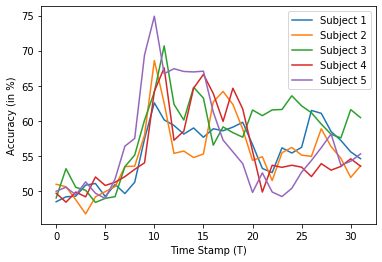

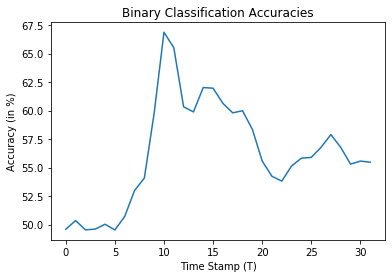

In [0]:
plt.figure()
accuracies = np.zeros((32, 1))
for i in range(1, 6):
 
  acc = np.load("/content/drive/My Drive/ML4DM_data/Results/S"+str(i)+"_accuracies.npy", allow_pickle=True)
  acc = acc.item()
  accuracies += np.asarray(list(acc.values())).reshape(-1, 1)
  plt.plot(list(acc.keys()), list(acc.values()), label = "Subject "+str(i))
plt.xlabel("Time Stamp (T)")
plt.ylabel("Accuracy (in %)")
plt.legend(loc = 0)
plt.show()

  
# print((accuracies))
plt.figure()
plt.title('Binary Classification Accuracies')
plt.plot(list(acc.keys()), accuracies/5)
plt.xlabel("Time Stamp (T)")
plt.ylabel("Accuracy (in %)")
# plt.savefig("S3_binary.png", dpi = 300)
plt.show()